## Evaluate different methods

**Goal:** Evaluate embedding models to match dialogs with (possibly) relevant facts  

### Constants

In [2]:
base_model_name = "BAAI/bge-base-en-v1.5"
custom_model_name = "./prev-model" # "julep-ai/dfe-base-en"
max_len = 512

### Imports and utils

In [3]:
%matplotlib inline

from functools import partial

from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from numpy import dot
from numpy.linalg import norm
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import SimilarityFunction, TripletEvaluator
from tqdm.auto import tqdm

### Datasets

- for evaluation: "stacked_samsum" (_test_ split)

In [4]:
# Remove '#' from the dialog and remove unnecessary columns
dataset = load_dataset(
    "julep-ai/dfe-stacked_samsum", 
    split="test",
)

filtered_dataset = dataset.filter(lambda row: row["is_truncated"] or row["is_augmented"])
len(filtered_dataset), len(dataset)

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/225418 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12754 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12254 [00:00<?, ? examples/s]

Filter:   0%|          | 0/12254 [00:00<?, ? examples/s]

(3656, 12254)

In [ ]:
dataset = filtered_dataset

In [1]:
def truncate_lines(row, num=2, min=3):
    """
    Split dialog into lines and then drop the last `num` lines,
    making sure there are at least `min` lines remaining.
    """

    dialogue = row["dialogue"]
    lines = dialogue.split("\n")

    # If too short, return as is
    if len(lines) - num > min:
        dialogue = "\n".join(lines[:-num])

    return dict(dialogue=dialogue)

In [ ]:
dataset = dataset.map(truncate_lines)

### Embed using base model (before tuning)

In [4]:
def embed(rows, model_name, wrap_items=False):
    from sentence_transformers import SentenceTransformer

    model = SentenceTransformer(model_name)
    
    dialogues = rows["dialogue"]
    summaries = rows["summary"]

    if wrap_items:
        dialogues = [dict(dialog=dialogue) for dialogue in dialogues]
        summaries = [dict(fact=summary) for summary in summaries]

    dialogue_embs = model.encode(dialogues).tolist()
    summary_embs = model.encode(summaries).tolist()

    return dict(
        dialogue_emb=dialogue_embs,
        summary_emb=summary_embs,
    )

In [5]:
def calc_cos_sim(row):
    dialogue_emb = row["dialogue_emb"]
    summary_emb = row["summary_emb"]

    a = np.array(dialogue_emb)
    b = np.array(summary_emb)

    cos_sim = dot(a, b)/(norm(a)*norm(b))

    return dict(similarity=cos_sim)

In [6]:
base_eval_ds = dataset.map(
    partial(embed, model_name=base_model_name),
    batch_size=5000, 
    batched=True,
)

Map:   0%|          | 0/37328 [00:00<?, ? examples/s]

In [7]:
base_eval_ds = base_eval_ds.map(calc_cos_sim, num_proc=100)

Parameter 'function'=<function calc_cos_sim at 0x7efa042012d0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map (num_proc=100):   0%|          | 0/37328 [00:00<?, ? examples/s]

### Evaluation (using base model)

1

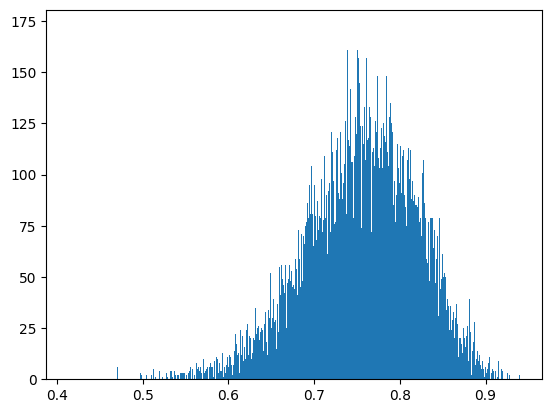

In [8]:
plt.hist(base_eval_ds["similarity"], bins=1000); 1

### Evaluation (after tuning)

In [10]:
custom_embed = partial(embed, model_name=custom_model_name, wrap_items=True)
custom_eval_ds = dataset.map(custom_embed, batched=True, batch_size=5000)

Map:   0%|          | 0/37328 [00:00<?, ? examples/s]

In [11]:
custom_eval_ds = custom_eval_ds.map(calc_cos_sim, num_proc=100)

Map (num_proc=100):   0%|          | 0/37328 [00:00<?, ? examples/s]

1

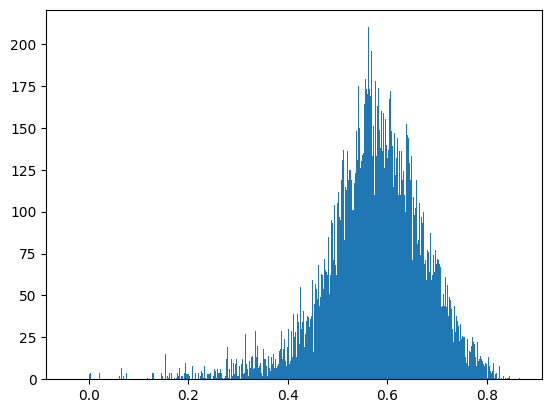

In [12]:
plt.hist(custom_eval_ds["similarity"], bins=1000); 1